In [135]:
import torch
import pathlib
import random
import math
import numpy as np
import torch.utils.data as tdata
import torch.optim as opt
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
import torch.utils.data as data
import matplotlib.pyplot as plt

In [208]:
#Changed the amount of epochs
n_epochs = 25
#Changed the batch sizes
batch_size_train = 16
batch_size_test = 8
learning_rate = 0.001
logging_interval = 1
validation_percent = 0.2
Training_Path =  ("/Users/Darius/Desktop/461/final_data/data/train")
Testing_Path =  ("/Users/Darius/Desktop/461/final_data/data/test")


In [213]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]), #Values are means and SD 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(60), 
    transforms.Resize(size=64),
    transforms.CenterCrop(size=(64,64))
   
])

#download the data
tr_dataset = torchvision.datasets.ImageFolder(root=Training_Path, transform=transform)


In [214]:
tr_idxs = list(range(len(tr_dataset)))
split = math.floor(len(tr_dataset)*validation_percent)
dataset_size = len(tr_dataset)
indicies = list(range(dataset_size))

In [215]:
train_data_loader = data.DataLoader(tr_dataset, batch_size=batch_size_train, sampler=SubsetRandomSampler(tr_idxs[split:]))
valid_data_loader = tdata.DataLoader(tr_dataset, batch_size=batch_size_test, sampler=SubsetRandomSampler(tr_idxs[split:]))

In [216]:
te_data = torchvision.datasets.ImageFolder(root=Testing_Path, transform=transform)
test_data_loader  = data.DataLoader(te_data, batch_size=batch_size_test, shuffle=True) 

In [217]:
classes=tr_dataset.classes
print(classes)



['benign', 'malignant']


In [201]:
from PIL import Image
img = Image.open                                                       \
(r"/Users/Darius/Desktop/461/final_data/data/train/benign/100.jpg")
img = transform(img)
print(img.size())

torch.Size([3, 64, 64])


In [218]:
def imshow(imgs, title):
  imgs=imgs.cpu()
  mean=torch.tensor([0.485,0.456,0.406]).view(1,3,1,1)
  std=torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)
  imgs=imgs*std+mean
  img_grid=make_grid(imgs,nrow=4)
  img_np=img_grid.numpy()
  img_np=np.transpose(img_np,(1,2,0))
  plt.figure(figsize=(8,4))
  plt.imshow(img_np)
  plt.title(title)
  plt.show()

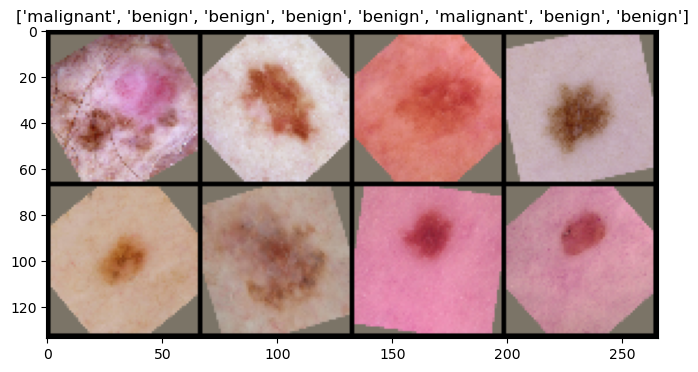

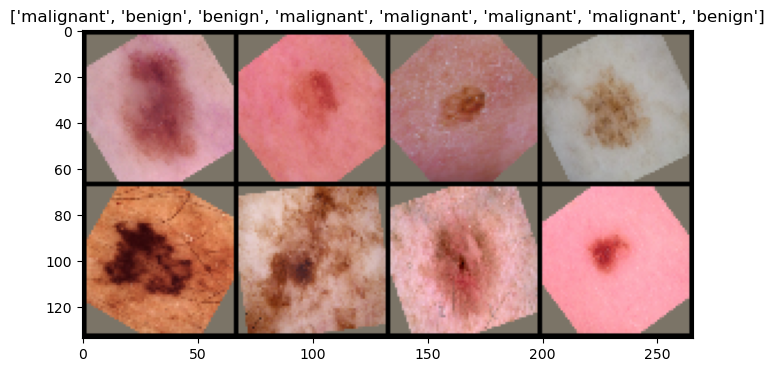

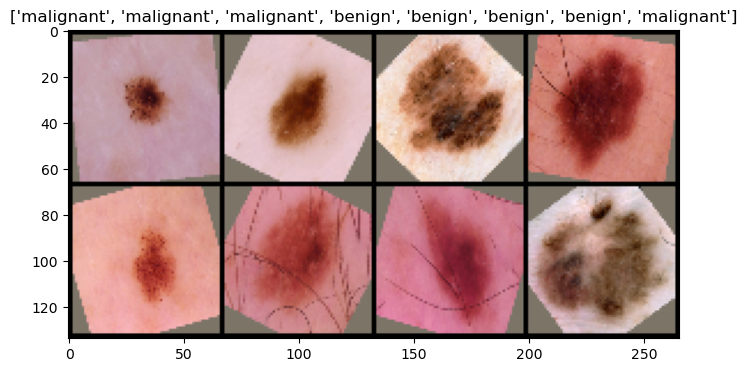

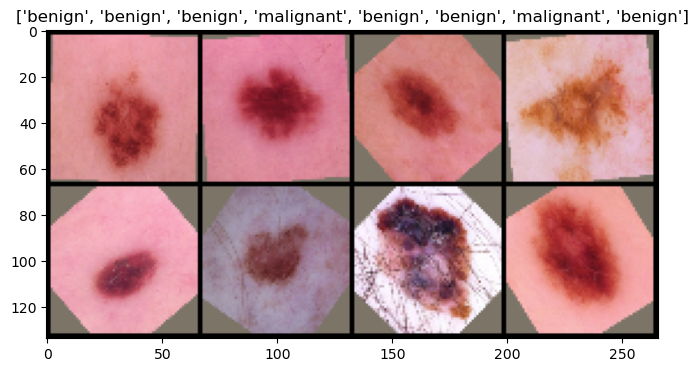

In [219]:
for i,batch in enumerate(test_data_loader):
  if i==4:
    break
  imgs,labels=batch
  imshow(imgs,str([classes[i] for i in labels]))

In [223]:
#Getting the number of training examples:
num_train =  (len(tr_dataset))

#Number of testing examples:
num_test = (len(te_data))

#Number of validation examples:
num_val = len(valid_data_loader.dataset)
# #Shape of our image:
# image_shape = train_data_loader[0].shape
# print(image_shape)

#Num of classes:
num_classes = len(np.unique(tr_dataset.classes))

print("Number of training examples: ", num_train)
print("Number of testing examples: ", num_test)
print("Number of validation examples: ", num_val)

print("Number of classes: ", num_classes)


Number of training examples:  2637
Number of testing examples:  660
Number of validation examples:  2637
Number of classes:  2


In [224]:
Operational_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [225]:
#Creating a Multinomial Logistic Regression Classifier
class NeuralNetwork(nn.Module):
  def __init__(self, n_in, n_out):
    #Always use the super
    super(NeuralNetwork, self).__init__()
    #Creating the layers need for the model 
    self.inputLayer = nn.Linear(n_in, 3000)
    self.hiddenLayer1 = nn.Linear(3000, 1000)
    self.hiddenLayer2 = nn.Linear(1000, 500)
    self.hiddenLayer3 = nn.Linear(500, 250)
    self.output = nn.Linear(250, 2)
    # Creating the different activation functions 
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
    #Using softmax in order to get the probabilites of the either classes. 
    self.softmax = nn.Softmax(dim=1)
    #Creating the weights and bias
    nn.init.xavier_uniform_(self.inputLayer.weight)
    nn.init.zeros_(self.inputLayer.bias)
    nn.init.xavier_uniform_(self.hiddenLayer1.weight)
    nn.init.zeros_(self.hiddenLayer1.bias)
    nn.init.xavier_uniform_(self.hiddenLayer2.weight)
    nn.init.zeros_(self.hiddenLayer2.bias)
    nn.init.xavier_uniform_(self.hiddenLayer3.weight)
    nn.init.zeros_(self.hiddenLayer3.bias)
    nn.init.xavier_uniform_(self.output.weight)
    nn.init.zeros_(self.output.bias)

  def forward(self, x):
    x = self.inputLayer(x)
    x = self.sigmoid(x)
    x = self.hiddenLayer1(x)
    x = self.sigmoid(x)
    x = self.hiddenLayer2(x)
    x = self.sigmoid(x)
    x = self.hiddenLayer3(x)
    x = self.sigmoid(x)
    x = self.output(x)
    x = self.softmax(x)
    return x

In [229]:
model = NeuralNetwork(12288,2).to(Operational_device)
lossfn = nn.CrossEntropyLoss(reduction='mean')
#Changed the optimizer
#Added regulation
optimizer = opt.Adam(model.parameters(), lr=learning_rate)

In [230]:
lossPlot = np.array([])
trLossPlot = np.array({})
valLossPlot = np.array({})
for e in range(n_epochs): #goes over the entire dataset at each iteration 
  model.train() #track gradients 
  tr_loss = 0
  # training step 
  for idx, batch in enumerate(train_data_loader, 0): #iterating over mini-batches
      optimizer.zero_grad()
      outputs = model(batch[0].view(-1,12288)) # [0] will get the input x from the mini batch
      loss = lossfn(outputs, batch[1]) # [1] will get the output y from the mini-batch
      loss.backward() #calcualtes gradients
      optimizer.step() #performs gradient descent update 
      tr_loss += loss.item()
  #Validation step
  model.eval() #no need to track gradients
  with torch.no_grad():
    val_loss = 0
    for idx, batch in enumerate(valid_data_loader, 0):
      outputs = model(batch[0].view(-1,12288))
      loss = lossfn(outputs, batch[1])
      val_loss += loss.item()
  
  #print some stats:
  if e % logging_interval == 0:
    print(f'Epoch: {e} TrLoss: {tr_loss/len(train_data_loader.sampler)} . ValLoss: {val_loss/len(valid_data_loader.sampler)}')





Epoch: 0 TrLoss: 0.04353828164638501 . ValLoss: 0.08779947712523112
Epoch: 1 TrLoss: 0.0392899200108379 . ValLoss: 0.08503767660161331
Epoch: 2 TrLoss: 0.03980560513186794 . ValLoss: 0.07368991033160856
Epoch: 3 TrLoss: 0.03863824668088795 . ValLoss: 0.07310874012974201
Epoch: 4 TrLoss: 0.03776376196558442 . ValLoss: 0.08058339728845804
Epoch: 5 TrLoss: 0.03827666390281153 . ValLoss: 0.09192619121752645
Epoch: 6 TrLoss: 0.03891851618109156 . ValLoss: 0.0735413452177816
Epoch: 7 TrLoss: 0.037384346551239775 . ValLoss: 0.07801334202572067
Epoch: 8 TrLoss: 0.037638727932179705 . ValLoss: 0.07529218533027794
Epoch: 9 TrLoss: 0.03750302862217076 . ValLoss: 0.07134667774794791
Epoch: 10 TrLoss: 0.03699941571572381 . ValLoss: 0.07277465428786255
Epoch: 11 TrLoss: 0.042795542136752775 . ValLoss: 0.07354194492242913
Epoch: 12 TrLoss: 0.04376703973912515 . ValLoss: 0.0933459596470069
Epoch: 13 TrLoss: 0.044225758342381336 . ValLoss: 0.07860046452820584
Epoch: 14 TrLoss: 0.03869328536976005 . Val

In [232]:
# print confusion matrix on test set
confusion_matrix = torch.zeros(len(tr_dataset.classes), len(tr_dataset.classes))
model.eval()
with torch.no_grad():
    for idx, batch in enumerate(test_data_loader, 0):
        outputs = model(batch[0].view(-1,12288))
        loss = lossfn(outputs, batch[1])
        _, preds = torch.max(outputs, 1)
        for t, p in zip(batch[1].view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
print(confusion_matrix.long())
true_positive = np.diag(confusion_matrix)
false_positive = (confusion_matrix) - true_positive
false_negative = (confusion_matrix) - true_positive
print(f'Overall Accuracy: {confusion_matrix.diag().sum() / confusion_matrix.sum()}')


tensor([[213, 147],
        [ 50, 250]])
Overall Accuracy: 0.7015151381492615
